## Base

### 1.1 Model Parameters

In [1]:
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 10
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False

In [2]:
#!pip install --user numpy
#!pip install pandas
#!python -m pip install -U matplotlib
#!python -m pip install -U scikit-image
#!pip install -U scikit-learn
#!pip install keras
#!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.morphology import binary_opening, disk, label

In [4]:
BASE_DIR = 'airbus-ship-detection'
TRAIN_DIR = BASE_DIR + '/train_v2/'
TEST_DIR = BASE_DIR + '/test_v2/'

In [5]:
train = os.listdir(TRAIN_DIR)
test = os.listdir(TEST_DIR)

print(f"Train files: {len(train)}. ---> {train[:3]}")
print(f"Test files :  {len(test)}. ---> {test[:3]}")

Train files: 192556. ---> ['00003e153.jpg', '0001124c7.jpg', '000155de5.jpg']
Test files :  15606. ---> ['00002bd58.jpg', '00015efb6.jpg', '00023d5fc.jpg']


In [6]:
masks = pd.read_csv(os.path.join(BASE_DIR, 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


### 1.4 utility functions

In [7]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):#тут побитовое или. типа была картинка с 1-ками для первого корабля и 0 для фона, а на второй картинке этот же корабль 0, 
    #а второй корабль уже единичка и когда побитовое или единичка выигрывает
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

### 1.5 Data Preparation Tools

In [8]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
masks.drop(['ships'], axis=1, inplace=True)
print(unique_img_ids.loc[unique_img_ids.ships>=2].head())
#showImage(unique_img_ids.loc[unique_img_ids.ships>=2].iloc[0].ImageId)

          ImageId  ships  has_ship
3   000194a2d.jpg      5       1.0
5   00021ddc3.jpg      9       1.0
6   0002756f7.jpg      2       1.0
11  000532683.jpg      2       1.0
15  0005d01c8.jpg      2       1.0


Max of ships :  15
Avg of ships :  0.4244115997424126


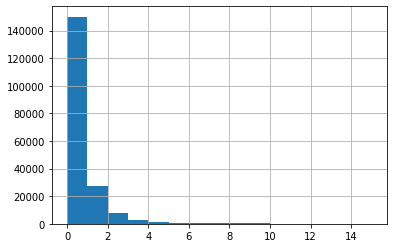

In [9]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())
print('Max of ships : ',unique_img_ids['ships'].max())
print('Avg of ships : ',unique_img_ids['ships'].mean())

## 2. Make dataset

### 2.1 Undersample Empty Images

19778 masks


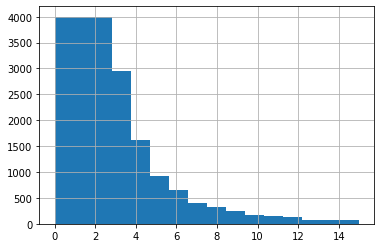

In [10]:
SAMPLES_PER_GROUP = 4000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

### 2-2. Split train & test set

In [11]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

44212 training masks
11059 validation masks


### 2-3. Image generator

In [12]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(TRAIN_DIR, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0).astype(np.float32)
                out_rgb, out_mask=[], []

In [13]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0.0 1.0


### 2-4. Make validatation set

In [14]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)


### 2-5. Data Augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x), next(g_y)

In [16]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


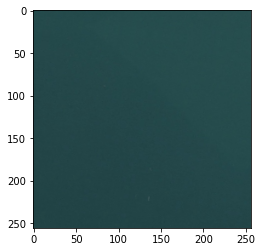

In [17]:
plt.imshow(t_x[37])

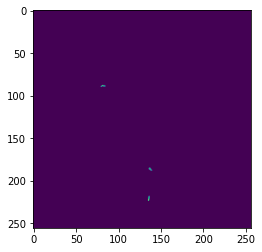

In [18]:
plt.imshow(t_y[37])

In [19]:
import gc; gc.enable() 

gc.collect()

22

## 3. Modeling

### 3-1. Base Model

In [20]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    

def unet(pretrained_weights = None, input_size = (256, 256, 3), NET_SCALING = NET_SCALING):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    seg_model = models.Model(inputs=[inputs], outputs=[d])
    #seg_model.summary()
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
        
    return seg_model

In [21]:
seg_model = unet()

### 3-2. loss function

In [22]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.losses import binary_crossentropy

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.dot(K.transpose(targets), inputs)   
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    intersection = K.dot(K.transpose(targets), inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

### 3-3. callbacks setting

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
weight_path="fullres_model & weights/{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, 
                                   patience=3, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

### 3-4. Training

In [24]:
epoch = 0
def fit():
    seg_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss = FocalLoss, metrics=[dice_coef])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [seg_model.fit(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 
                                           )]
    return loss_history

while True:
    loss_history = fit()
    #if np.min([mh.history['val_dice_coef'] for mh in loss_history]) < -0.2:
      #break

Epoch 1/99
10/10 [==============================] - 18s 1s/step - loss: 0.0472 - dice_coef: 0.0067 - val_loss: 0.0256 - val_dice_coef: 0.0076

Epoch 00001: saving model to fullres_model & weights\seg_model_weights.best.hdf5
Epoch 2/99
10/10 [==============================] - 10s 1s/step - loss: 0.0146 - dice_coef: 0.0080 - val_loss: 0.0163 - val_dice_coef: 0.0084

Epoch 00002: saving model to fullres_model & weights\seg_model_weights.best.hdf5
Epoch 3/99
10/10 [==============================] - 10s 1s/step - loss: 0.0094 - dice_coef: 0.0089 - val_loss: 0.0090 - val_dice_coef: 0.0120

Epoch 00003: saving model to fullres_model & weights\seg_model_weights.best.hdf5
Epoch 4/99
10/10 [==============================] - 10s 1s/step - loss: 0.0091 - dice_coef: 0.0139 - val_loss: 0.0080 - val_dice_coef: 0.0140

Epoch 00004: saving model to fullres_model & weights\seg_model_weights.best.hdf5
Epoch 5/99
10/10 [==============================] - 10s 1s/step - loss: 0.0082 - dice_coef: 0.0172 - val


KeyboardInterrupt



### 3-5. Full Resolution Mode

In [25]:
#if IMG_SCALING is not None:
    #fullres_model = models.Sequential()
    #fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    #fullres_model.add(seg_model)
    #fullres_model.add(layers.UpSampling2D(IMG_SCALING))
#else:
fullres_model = seg_model
fullres_model.save('fullres_model & weights/fullres_model.h5')

In [26]:
#!pip install opencv-python
import tensorflow as tf
import cv2
rgb_path = os.path.join(TEST_DIR,'00dc34840.jpg')#'00c3db267.jpg')
img = cv2.imread(rgb_path)/255
img = img[::IMG_SCALING[0], ::IMG_SCALING[1]]
img = tf.expand_dims(img, axis=0)
pred = fullres_model.predict(img)
print(pred[pred<0])

[]


In [29]:
def gen_pred(test_dir, img, model):
    rgb_path = os.path.join(TEST_DIR,img)
    img = cv2.imread(rgb_path)
    img = img[::IMG_SCALING[0], ::IMG_SCALING[1]]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred = np.squeeze(pred, axis=0)
    return cv2.imread(rgb_path), pred

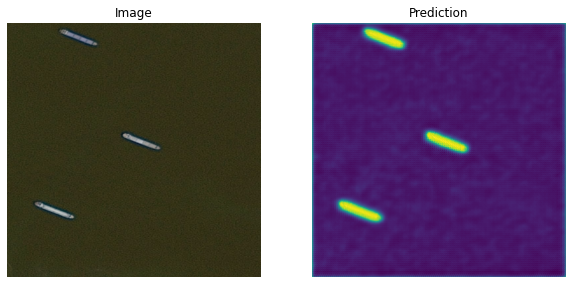

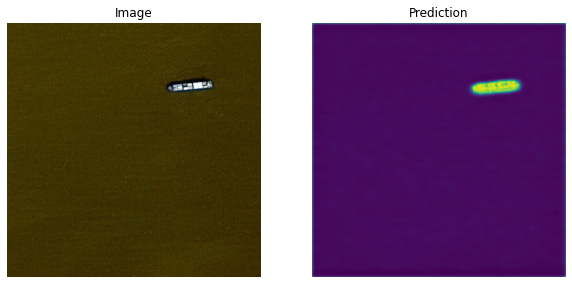

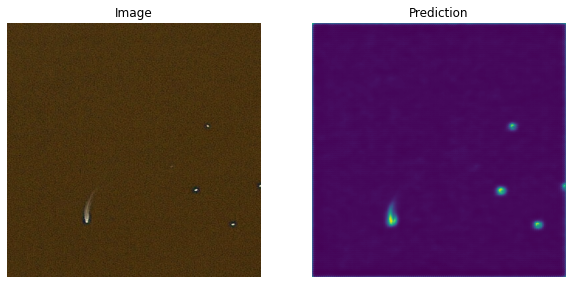

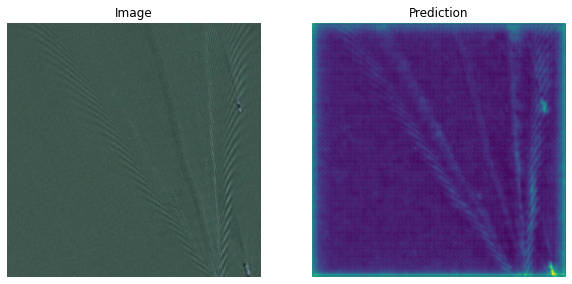

In [30]:
from matplotlib import pyplot as plt
test_imgs = ['00dc34840.jpg', '00c3db267.jpg', '00aa79c47.jpg', '00a3a9d72.jpg']
%matplotlib inline

rows = 1
columns = 2
for i in range(len(test_imgs)):
    img, pred = gen_pred(TEST_DIR, test_imgs[i], fullres_model)
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(pred, interpolation=None)
    plt.axis('off')
    plt.title("Prediction")